In [ ]:
import numpy as np
import tensorflow 
from tensorflow import keras
from tensorflow.keras import layers
import gym
import tensorflow as tf
import time
from matplotlib import animation
import matplotlib.pyplot as plt
from google.colab import drive
import os
import pickle
from matplotlib import animation
from collections import deque
Root='/content/drive/MyDrive/Colab Notebooks/RL/'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def create_model():
    num_actions=4
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu",kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2))(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu",kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2))(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu",kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2))(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu",kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2))(layer4)
    action = layers.Dense(num_actions, activation="linear",kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2))(layer5)

    return keras.Model(inputs=inputs, outputs=action)

class DQN_Agent():
    def __init__(self, epsilon =0.9, gamma = 0.99,update_after_actions = 4,
                 epsilon_greedy_frames = 1_000_000, epsilon_random_frames =50000,
                 epsilon_min = 0.1, max_memory_length = 500000,
                 update_network = 10000, batch_size =32,num_actions=4):
        
        #initialization of the parameters of the agent
        self.max_memory_length = max_memory_length
        self.loss_function = tensorflow.keras.losses.Huber()
        self.optimizer = tensorflow.keras.optimizers.Adam(learning_rate = 0.00025, clipnorm = 1)
        self.epsilon_random_frames = epsilon_random_frames
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon_min = epsilon_min
        self.epsilon_greedy_frames = epsilon_greedy_frames
        self.epsilon = epsilon
        self.epsilon_interval = 1- self.epsilon_min
        self.update_after_actions = update_after_actions
        self.buffer_actions = deque(maxlen = max_memory_length)
        self.buffer_state = deque(maxlen = max_memory_length)
        self.buffer_nextstate = deque(maxlen = max_memory_length)
        self.buffer_done = deque(maxlen = max_memory_length)
        self.buffer_rewards = deque(maxlen = max_memory_length)

        self.frames = 0
        self.update_network = update_network
        self.model = create_model()
        self.target_model = create_model()
        self.target_model.set_weights(self.model.get_weights())
        self.num_actions=num_actions


    def update_replay_buffer(self,action,state,state_next,done,reward):
        #filling the replay memory with the recent state, next state ,action,reward , and done information
        self.buffer_actions.append(action)
        self.buffer_state.append(state)
        self.buffer_nextstate.append(state_next)
        self.buffer_done.append(done)
        self.buffer_rewards.append(reward)
    
    def update_weights(self):
      #update the weights of the target model 
        self.target_model.set_weights(self.model.get_weights())
        
    def choose_action(self,state):
      #choosing an action based on an epsilon greedy policy
        self.frames += 1
        if np.random.uniform(0,1) < self.epsilon or self.frames <self.epsilon_random_frames:
            action = np.random.choice(np.arange(4))
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            # outputs the Q value for each action 
            Q_val = self.model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(Q_val[0]).numpy()
        
        #epsilon decay
        self.epsilon -= self.epsilon_interval /self.epsilon_greedy_frames
        # epsilon capped at minimum epsilon (0.1) 
        self.epsilon = max(self.epsilon,self.epsilon_min)
        
        return action

    def choose_action_eval(self,state):
      #same as the training but used in the evaluation to output the Q values
        self.frames += 1
        if np.random.uniform(0,1) < self.epsilon or self.frames <self.epsilon_random_frames:
            action = np.random.choice(np.arange(4))
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            Q_val = self.model(state_tensor, training=False)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            Q_val = self.model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(Q_val[0]).numpy()

        self.epsilon -= self.epsilon_interval /self.epsilon_greedy_frames
        self.epsilon = max(self.epsilon,self.epsilon_min)
        
        return action,np.array(Q_val[0])
        
    def learn(self):
      #based on the hyperparameters , the agent samples states from the replay memory to update its weights
        if self.frames % self.update_after_actions==0 and len(self.buffer_actions) > self.batch_size:
            indices = np.random.choice(range(len(self.buffer_actions)), size = self.batch_size)
            state_sample = np.array([self.buffer_state[i] for i in indices])
            state_next_sample = np.array([self.buffer_nextstate[i] for i in indices])
            rewards_sample = [self.buffer_rewards[i] for i in indices]
            action_sample = [self.buffer_actions[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(self.buffer_done[i]) for i in indices])
            
            
            future_rewards = self.target_model.predict(state_next_sample)
            updated_q_values = rewards_sample + self.gamma *tf.reduce_max(future_rewards, axis =1)
            
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample
            
            masks = tf.one_hot(action_sample, self.num_actions)
            
            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = self.model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = self.loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        #update the weights of the target network each 10000 frames 
        if self.frames % self.update_network == 0:
            self.update_weights()

    
    def save_buffer(self,i):
      #save the current buffer in case of programm crashes
        with open(Root+'app/new_run/buffer/history.txt','w') as b:
          b.write(f'Latest Frames Saved : {i}')
          b.write('\n')
        pickle.dump( self.buffer_rewards, open( Root+'app/new_run/buffer/buffer_rewards.p', "wb" ))
        pickle.dump( self.buffer_state, open( Root+'app/new_run/buffer/buffer_state.p', "wb" ))
        pickle.dump( self.buffer_nextstate, open( Root+'app/new_run/buffer/buffer_nextstate.p', "wb" ))
        pickle.dump( self.buffer_actions, open( Root+'app/new_run/buffer/buffer_actions.p', "wb" ))
        pickle.dump( self.buffer_done, open( Root+'app/new_run/buffer/buffer_done.p', "wb" ))
    
    def load_buffer(self):
      #import the saved buffer to continue training
      with open(Root+'app/new_run/buffer/buffer_rewards.p','rb') as f:
        self.buffer_rewards = pickle.load(f)
      with open(Root+'app/new_run/buffer/buffer_state.p','rb') as f:
        self.buffer_state = pickle.load(f)
      with open(Root+'app/new_run/buffer/buffer_nextstate.p','rb') as f:
        self.buffer_nextstate = pickle.load(f)
      with open(Root+'app/new_run/buffer/buffer_actions.p','rb') as f:
        self.buffer_actions = pickle.load(f)
      with open(Root+'app/new_run/buffer/buffer_done.p','rb') as f:
        self.buffer_done = pickle.load(f)
      print('----------Loaded Buffer Succesfully----------')

    def load_checkpoint(self,frames,model_f):
      #update the values of the parameters in case the training was stopped and continue from that point
      self.frames = frames
      self.epsilon = 0.1
      self.load_model(model_f)
      self.load_buffer()

    def eval_load(self,frames,model_f):
      #update the values of the parameters for correct evaluation

      self.frames = frames
      self.epsilon = 0.01
      self.load_model(model_f)
      self.epsilon_min=0.01

    def save_model(self,i):
      #save the model weights
        self.model.save(Root+'app/bigchin/picked_w/model'+str(i)+'.h5')
        print('----------Saved Model {} Succesfully----------'.format(i))


    def load_model(self,i):
      #load the model weights
        self.model = create_model()
        self.model.load_weights(Root+'app/bigchin/picked_w/model'+str(i)+'.h5')
        self.update_weights()
        print('----------Loaded Model {} Succesfully----------'.format(i))
        
def _train():
    agent = DQN_Agent()

    # load_frames=11000000
    # load_model=110
    # ep=50000
    # agent.load_checkpoint(load_frames,load_model)

    env=gym.make("BreakoutNoFrameskip-v4")
    env=gym.wrappers.AtariPreprocessing(env, frame_skip=4,scale_obs=True,terminal_on_life_loss=True)
    env=gym.wrappers.FrameStack(env,4)
    num_episodes=2000000

    for i in range(num_episodes):
        env.reset()
        state,_,_,_=env.step(1)
        score =0 
        done = False
        while not done:
            s=np.transpose(state,(1,2,0))
            action = agent.choose_action(s)
            new_state, reward, done, info = env.step(action)
            score += reward
            ns=np.transpose(new_state,(1,2,0))
            agent.update_replay_buffer(action,s,ns,done,reward)
            agent.learn()
            state = new_state
    
            if (agent.frames % 500000)==0 :
              frames2=int(agent.frames/100000)
              agent.save_model(frames2)
              agent.save_buffer(agent.frames)
              t = time.localtime()
              current_time = time.strftime("%H:%M:%S", t)
              with open(Root+'app/new_run/checkpoint.txt','a') as c:
                  c.write(f'Checkpoint :: Episode {i},Frames={agent.frames},Epsilon={agent.epsilon},time : {current_time}')
                  c.write('\n')
              print()
              print(f'Checkpoint :: Episode {i},Frames={agent.frames},Epsilon={agent.epsilon}, time : {current_time})',flush=True)
              print()
              
        if (i%10)==0:
            t = time.localtime()
            current_time = time.strftime("%H:%M:%S", t)
            with open(Root+'app/new_run/log.txt','a') as l:
                l.write(f'Episode:{i} :: Frames:{agent.frames} and Score:{score},time : {current_time}')
                l.write('\n')
            print(f'Episode:{i} :: Frames:{agent.frames} and Score:{score},time : {current_time}',flush=True)

def _eval():
    agent = DQN_Agent()
    env=gym.make("BreakoutNoFrameskip-v4")
    env=gym.wrappers.AtariPreprocessing(env, frame_skip=4,scale_obs=True,terminal_on_life_loss=True)
    env=gym.wrappers.FrameStack(env,4)
    evaluation={}
    spec={}
    gifaki={}
    gifaki2={}
    # one=[0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
    # two=[55,60,65,70,75,80,85,90]
    # three=[95,100,105,110]
    # four=[115,120,125,130,135]
    # disp=[0,5,20,50]
    alls =[k for k in range (0,136,5)]
    
    for m in alls:
        agent.eval_load(1000000,m)
        scores=[]
        max_rew=-1
        for i in range(100):
            episode=[]
            episodeQ=[]
            env.reset()
            state,_,_,_=env.step(1)
            score =0 
            info ={'ale.lives':1}
            done=False
            while not info['ale.lives']==0:
                if done :
                  state,_,_,_=env.step(1)
                episode.append(env.render(mode="rgb_array"))
                s=np.transpose(state,(1,2,0))
                action,Q = agent.choose_action_eval(s)
                episodeQ.append(Q)
                new_state, reward, done, info = env.step(action)
                score += reward
                state = new_state
            scores.append(score)
            if score>max_rew :
              max_rew=score
              gifaki[m]=episode
              gifaki2[m]=episodeQ

        scores=np.array(scores)
        evaluation[m]=scores
        spec[m]={'min':np.min(scores),'mean':np.mean(scores),'max':np.max(scores)}
        print('For model :',m)
        print(spec[m])
        print()
    return evaluation,spec,gifaki,gifaki2

In [ ]:
def random_run():
  #simulates a single random run
  env=gym.make("BreakoutNoFrameskip-v4")
  env=gym.wrappers.AtariPreprocessing(env, frame_skip=4,scale_obs=True,terminal_on_life_loss=True)
  env=gym.wrappers.FrameStack(env,4)
  episode=[]
  env.reset()
  state,_,_,_=env.step(1)
  score =0 
  info ={'ale.lives':1}
  done=False
  while not info['ale.lives']==0:
      if done :
        state,_,_,_=env.step(1)
      episode.append(env.render(mode="rgb_array"))
      action= np.random.randint(0,4)
      new_state, reward, done, info = env.step(action)
      score += reward
      state = new_state

  return score,episode
  
def plot_evaluation(spec,runs):
  #plot function for evaluation of performance
  avg=[spec[m]['mean'] for m in spec.keys()]
  maxi=[spec[m]['max'] for m in spec.keys()]
  mini=[spec[m]['min'] for m in spec.keys()]
  frames=[str(m/10)+' m' for m in spec.keys()]
  fig, ax1 = plt.subplots(figsize=(15,8))

  s=[np.std(runs[m])for m in runs.keys()]
 
  ax1.plot(avg,label='Average Score')
  ax1.plot(maxi,label='Maximum Score')
  ax1.plot(mini,label='Minimum Score')
  upper_bound=[avg[m]+s[m] for m in range(len(s))]
  lower_bound=[avg[m]-s[m] for m in range(len(s))]

  ax1.fill_between(frames,upper_bound,lower_bound,color='tab:blue',alpha=.3,label='Standard Deviation')
  ax1.axhline(y=30.8,color='k', linestyle='--',label='Human Average')
  ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  ax1.set(xlabel='Frames', ylabel='Score',title='Scores Averaged in 100 episodes')
  ax1.set_xticks(range(len(frames)))
  ax1.set_xticklabels(frames,rotation=45)

  plt.grid()
  plt.show()
  
def generate_video(frames,stage,folder='app/bigchin/finalgifs2/'):
  # create video of the game playing
  img = [] 
  fig = plt.figure()
  plt.axis('off')

  for i in range(len(frames)):
      img.append([plt.imshow(frames[i],animated=True)])
  print('finished')
  ani = animation.ArtistAnimation(fig, img, interval=50, blit=True,
                                  repeat_delay=1000)
  ani.save(Root+folder+'frames'+str(stage)+'.mp4')
  plt.show()

def generate_video2(frames,stage,folder='app/bigchin/finalgifs2/'):
    # create video of the live Q values as the game plays
    img = [] 
    fig = plt.figure()

    for i in range(len(frames)):
        k=np.argmax(frames[i])
        colr=['tab:blue','tab:blue','tab:blue','tab:blue']
        colr[k]='tab:green'
        img.append(plt.bar(['NOOP', 'FIRE', 'RIGHT', 'LEFT'],frames[i],color=colr))
    print('finished')
    ani = animation.ArtistAnimation(fig, img, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save(Root+folder+'Q'+str(stage)+'.mp4')
    plt.show()

def animate_subplots(gif,gif2,m):
  for i in range(len(gif2[m])):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.bar(['NOOP', 'FIRE', 'RIGHT', 'LEFT'],gif2[m][i])
    ax2.imshow(gif[m][i])
    plt.show()
    fig.savefig(Root+'app/Results/plots/Qfig'+str(i)+'.png')

  img = [] 
  fig = plt.figure()
  plt.axis('off')
  folder='app/bigchin/gifs/'
  for i in range(1,len(gif2[m])):
      k=plt.imread(Root+'app/Results/plots/Qfig'+str(i)+'.png')
      # if i in [12,13,14,44,45,46,79,80,81,109,110,111,134,135,136]:
      #   for _ in range(5):
      #     img.append([plt.imshow(k,animated=True)])
      img.append([plt.imshow(k,animated=True)])
  print('finished')
  ani = animation.ArtistAnimation(fig, img, interval=120, blit=True,
                                  repeat_delay=1000)
  ani.save(Root+folder+'Qtest'+str(m)+'.mp4')
  plt.show()

In [ ]:
# Train the agent
_train()

In [ ]:
# Evalution of the agent
ev,spec,gif,gif2=_eval()
# Video generation of the evaluated runs
for m in spec.keys():
  generate_video(gif[m],m)
  generate_video2(gif[m],m)

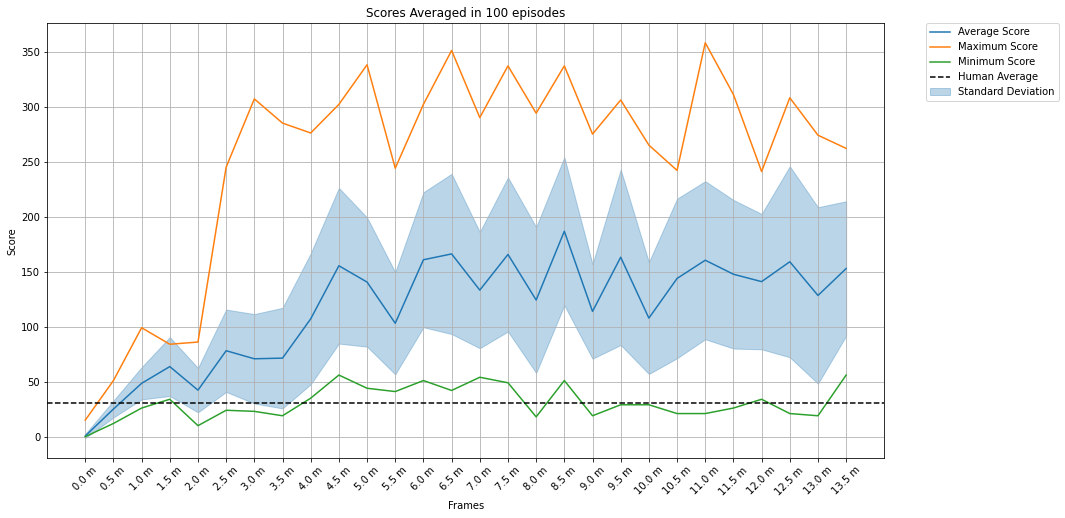

In [ ]:
plot_evaluation(spec,ev)